# Imports

In [1]:
import os
import numpy as np
import sys
import pickle
import sed_eval
#%load_ext autoreload

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

#%autoreload 2
from src.models.single_stage_yamnet_frame import *
from src.config import DETECTION_TRAIN_PATH, DETECTION_TEST_PATH, CLASSES
from src.utils.audio_to_spectrograms import display_spectrogram

2025-12-08 23:15:48.732945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 23:15:48.771407: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 23:15:50.113281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 23:16:06.239432: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
data_events = pickle.load(open('data/processed/yamnet/spectrograms_train_list.pkl', 'rb'))
data = pickle.load(open('data/processed/yamnet/spectrograms_train.pkl', 'rb'))
print(data.keys())
class_to_id = {c:(i+1) for i,c in enumerate(CLASSES)} # id to start from 1, 0 is reserved for no event
print("Classes:", CLASSES)

dict_keys(['sr', 'S_db', 'files', 'onset', 'offset', 'event_label', 'background_label'])
Classes: ['cough', 'dog_bark', 'gun_shot', 'siren', 'car_horn']


In [3]:
# manual train test split (stratified)
np.random.seed(0)
train_size = 0.8
train_idx = []
for label in np.unique(data['event_label']):
    choices = np.where(data['event_label'] == label)[0]
    train_idx.append(np.sort(np.random.choice(choices, size = int(np.round(len(choices)*train_size)), replace = False)))
train_idx = np.sort(np.concatenate(train_idx))
val_idx = [i for i in range(len(data['event_label'])) if i not in train_idx]
len(train_idx)

2001

In [4]:
filepaths = [os.path.join(DETECTION_TRAIN_PATH, file) for file in data['files']]
labels = [class_to_id[c] for c in data['event_label']]

train_files = [filepaths[i] for i in train_idx]
train_labels = [(data['onset'][i], data['offset'][i], labels[i]) for i in train_idx]
val_files = [filepaths[i] for i in val_idx]
val_labels = [(data['onset'][i], data['offset'][i], labels[i]) for i in val_idx]
val_onsets = [data['onset'][i] for i in val_idx]
val_offsets = [data['offset'][i] for i in val_idx]

In [5]:
# uncomment to train model again
#trainer = Trainer(train_files, train_labels, val_files, val_labels, mode = 'train', extra_layer = False, checkpoint_path = 'checkpoints/yamnet_framewise.keras')
trainer = Trainer(train_files, train_labels, val_files, val_labels, mode = 'train', extra_layer = True, checkpoint_path = 'checkpoints/yamnet_framewise_layer.keras')
trainer.train()

Pre-computing embeddings for 2500 files into data/cache/single_stage_yamnet_embeddings...


100%|██████████| 2500/2500 [00:04<00:00, 551.26it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 256)      │       262,400 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 6)        │         1,542 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,942 (1.01 MB)

 Trainable params: 263,942 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - accuracy: 0.8118 - loss: 0.7987 - val_accuracy: 0.8606 - val_loss: 0.4875 - learning_rate: 1.0000e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.8831 - loss: 0.4330 - val_accuracy: 0.8875 - val_loss: 0.3978 - learning_rate: 1.0000e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.8976 - loss: 0.3821 - val_accuracy: 0.8988 - val_loss: 0.3681 - learning_rate: 1.0000e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9037 - loss: 0.3603 - val_accuracy: 0.9044 - val_loss: 0.3531 - learning_rate: 1.0000e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9086 - loss: 0.3459 - val_accuracy: 0.9079 - val_loss: 0.3415 - learning_rate: 1.0000e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9109 - loss: 0.3357 - val_accuracy: 0.9104 - val_loss: 0.3336 - learning_rate: 1.0000e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1

# Inference


In [5]:
trained = Trainer(mode = 'infer', checkpoint_path = 'checkpoints/yamnet_framewise_layer.keras')
trained.load_model(checkpoint_path = 'checkpoints/yamnet_framewise_layer.keras')

Loaded model from checkpoints/yamnet_framewise_layer.keras


## Get test set event predictions

In [6]:
data_test = pickle.load(open('data/processed/yamnet/spectrograms_test.pkl', 'rb'))
test_files = [os.path.join(DETECTION_TEST_PATH, file) for file in data_test['files']]
precompute_embeddings(test_files)

Pre-computing embeddings for 500 files into data/cache/single_stage_yamnet_embeddings...


100%|██████████| 500/500 [00:00<00:00, 535.10it/s]


In [8]:
trained.inference(test_files, med_filter=True)

100%|██████████| 500/500 [00:25<00:00, 19.27it/s] 


Saved YAMNet predicted events pickle file to outputs/single_stage_yamnet.json


{'test_snipped_scene_0000.wav': [{'file': 'test_snipped_scene_0000.wav',
   'event_onset': 0.96,
   'event_offset': 3.84,
   'event_label': 'siren'},
  {'file': 'test_snipped_scene_0000.wav',
   'event_onset': 3.84,
   'event_offset': 5.76,
   'event_label': 'car_horn'}],
 'test_snipped_scene_0001.wav': [{'file': 'test_snipped_scene_0001.wav',
   'event_onset': 8.16,
   'event_offset': 9.6,
   'event_label': 'cough'}],
 'test_snipped_scene_0002.wav': [{'file': 'test_snipped_scene_0002.wav',
   'event_onset': 3.36,
   'event_offset': 5.76,
   'event_label': 'cough'}],
 'test_snipped_scene_0003.wav': [{'file': 'test_snipped_scene_0003.wav',
   'event_onset': 4.32,
   'event_offset': 7.68,
   'event_label': 'gun_shot'}],
 'test_snipped_scene_0004.wav': [{'file': 'test_snipped_scene_0004.wav',
   'event_onset': 9.6,
   'event_offset': 13.92,
   'event_label': 'car_horn'}],
 'test_snipped_scene_0005.wav': [{'file': 'test_snipped_scene_0005.wav',
   'event_onset': 9.6,
   'event_offset': 13.

## Sample prediction

In [9]:
# format reference events
reference_events = {ref_event['file']: [{'file':ref_event['file'], 
                     'event_onset':ref_event['onset'], 
                     'event_offset':ref_event['offset'],
                     'event_label':ref_event['event_label']}]
                     for ref_event in data_events}

In [10]:
i = 0
test_path = val_files[i]
print(f'Actual label: {CLASSES[val_labels[i][2] - 1]}')
print(f'Actual onset: {val_onsets[i]}')
print(f'Actual offset: {val_offsets[i]}')

frame_probs = trainer.predict_frames(test_path, med_filter = True)  # shape: (n_frames, n_classes)
frame_preds = np.argmax(frame_probs, axis=-1) 
print(frame_probs.shape)
print([CLASSES[i-1] if i!= 0 else '' for i in frame_preds])
actual = labels_to_frames(val_labels[i])
print([CLASSES[i-1] if i!= 0 else '' for i in actual])

estimated_event = trainer.predict_events(test_path)
print(estimated_event)
ref_event = reference_events[os.path.basename(test_path)]
print(ref_event)

event_based_metrics_test = sed_eval.sound_event.EventBasedMetrics(CLASSES)
segment_based_metrics_test = sed_eval.sound_event.SegmentBasedMetrics(CLASSES)
event_based_metrics_test.evaluate(
    reference_event_list=ref_event,
    estimated_event_list=estimated_event
)
segment_based_metrics_test.evaluate(
    reference_event_list=ref_event,
    estimated_event_list=estimated_event
)
print(event_based_metrics_test)
print(segment_based_metrics_test)

Actual label: siren
Actual onset: 1.5601864044243652
Actual offset: 5.560186404424365
(41, 6)
['', '', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'dog_bark', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['', '', '', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', 'siren', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
[{'file': 'train_snipped_scene_0000.wav', 'event_onset': 0.96, 'event_offset': 5.279999999999999, 'event_label': 'siren'}, {'file': 'train_snipped_scene_0000.wav', 'event_onset': 5.279999999999999, 'event_offset': 5.76, 'event_label': 'cough'}]
[{'file': 'train_snipped_scene_0000.wav', 'event_onset': np.float64(1.5601864044243652), 'event_offset': np.float64(5.560186404424365), 'event_label': 'siren'}]
Event based metrics (onset-offset)
  Evaluated length                  :

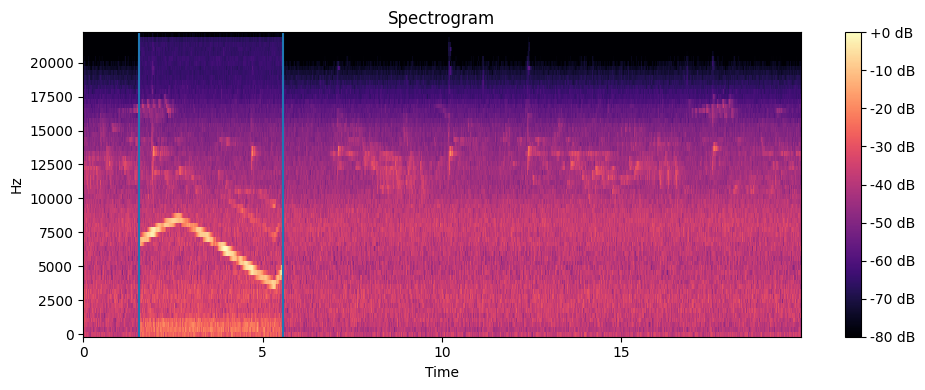

In [11]:
display_spectrogram(data['S_db'][val_idx[i]], data['sr'], val_onsets[i], val_offsets[i])